In [1]:
%cd ../..

/home/eli/AnacondaProjects/combinators


In [2]:
import logging

import numpy as np
import probtorch
import torch

from examples.dynamical_ball import dynamical_ball
from examples.bouncing_ball import bouncing_ball_data
from combinators.model import foldable
from combinators.inference import importance, mcmc
from combinators import utils

In [3]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
## dataset parameters
T = 100 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [6]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [7]:
num_particles = (100,)

In [8]:
init_bouncing_ball = dynamical_ball.InitBallDynamics(batch_shape=num_particles)

In [9]:
bouncing_ball_step = dynamical_ball.StepBallDynamics(batch_shape=num_particles)

In [10]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['velocity_%d' % (i-1)] = displacements[i-1]
    
    return trajectory, displacements, data

In [11]:
def accumulate_trajectory(inference):
    initial_position = inference['Reduce/Step(0)/InitBallDynamics']['position_0'].value
    initial_velocity = inference['Reduce/Step(0)/InitBallDynamics']['velocity_0'].value
    velocities = torch.zeros(initial_velocity.shape[0], T + 1, 2)
    velocities[:, 0] = initial_velocity
    for t in range(1, T + 1):
        velocities[:, t] = inference['Reduce/Step(%d)/StepBallDynamics' % (t-1)]['velocity_%d' % t].value
    trajectory = dynamical_ball.simulate_trajectory(initial_position, initial_velocity, T, velocities=velocities)
    return trajectory[:, :, 0, :]

In [12]:
def graph_trajectory(positions, T, s, name, show=True):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T+1))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    if show:
        plt.show()
    else:
        plt.savefig(name % s)

In [13]:
def graph_original_trajectory(trajectory, T, s, show=True):
    positions = trajectory[:, :2]
    graph_trajectory(positions, T, s, 'trajectory_%d.pdf', show=show)

In [14]:
def graph_inferred_trajectory(positions, T, s, show=True):
    graph_trajectory(positions, T, s, 'inferred_trajectory_%d.pdf', show=show)

In [15]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [16]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [17]:
def proposal_model():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return foldable.Reduce(foldable.Step(step_proposal, initializer=init_proposal),
                           lambda: range(T))

In [18]:
def training_initializer():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    return importance.Importance(init_bouncing_ball, init_proposal)

In [19]:
def training_step():
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return importance.Importance(bouncing_ball_step, step_proposal)

In [20]:
def training_model():
    return foldable.Reduce(foldable.Step(training_step(), initializer=training_initializer()), lambda: range(T))

02/25/2019 14:39:06 ELBO=-4.47309662e+02 at epoch 1
02/25/2019 14:39:06 ELBO=-4.25348267e+02 at epoch 2
02/25/2019 14:39:06 ELBO=-4.50573303e+02 at epoch 3
02/25/2019 14:39:06 ELBO=-4.38320190e+02 at epoch 4
02/25/2019 14:39:07 ELBO=-4.12741760e+02 at epoch 5
02/25/2019 14:39:07 ELBO=-4.30613861e+02 at epoch 6
02/25/2019 14:39:07 ELBO=-4.42421295e+02 at epoch 7
02/25/2019 14:39:07 ELBO=-4.28078644e+02 at epoch 8
02/25/2019 14:39:07 ELBO=-4.45091736e+02 at epoch 9
02/25/2019 14:39:07 ELBO=-4.28063751e+02 at epoch 10
02/25/2019 14:39:08 ELBO=-4.11480835e+02 at epoch 11
02/25/2019 14:39:08 ELBO=-4.25979584e+02 at epoch 12
02/25/2019 14:39:08 ELBO=-4.24602631e+02 at epoch 13
02/25/2019 14:39:08 ELBO=-4.08235260e+02 at epoch 14
02/25/2019 14:39:08 ELBO=-4.10580933e+02 at epoch 15
02/25/2019 14:39:09 ELBO=-4.15125519e+02 at epoch 16
02/25/2019 14:39:09 ELBO=-4.01425964e+02 at epoch 17
02/25/2019 14:39:09 ELBO=-4.00281311e+02 at epoch 18
02/25/2019 14:39:09 ELBO=-4.00729248e+02 at epoch 19
02

Epoch   417: reducing learning rate of group 0 to 5.0000e-02.


02/25/2019 14:40:31 ELBO=-1.52351852e+02 at epoch 420
02/25/2019 14:40:31 ELBO=-1.56924667e+02 at epoch 421
02/25/2019 14:40:31 ELBO=-1.43057037e+02 at epoch 422
02/25/2019 14:40:31 ELBO=-1.35524460e+02 at epoch 423
02/25/2019 14:40:32 ELBO=-1.45034210e+02 at epoch 424
02/25/2019 14:40:32 ELBO=-1.40266113e+02 at epoch 425
02/25/2019 14:40:32 ELBO=-1.30163116e+02 at epoch 426
02/25/2019 14:40:32 ELBO=-1.15713264e+02 at epoch 427
02/25/2019 14:40:33 ELBO=-1.25576454e+02 at epoch 428
02/25/2019 14:40:33 ELBO=-1.21473564e+02 at epoch 429
02/25/2019 14:40:33 ELBO=-1.33050308e+02 at epoch 430
02/25/2019 14:40:33 ELBO=-1.27613075e+02 at epoch 431
02/25/2019 14:40:33 ELBO=-1.25756775e+02 at epoch 432
02/25/2019 14:40:34 ELBO=-1.26556129e+02 at epoch 433
02/25/2019 14:40:34 ELBO=-1.24534897e+02 at epoch 434
02/25/2019 14:40:34 ELBO=-1.21548637e+02 at epoch 435
02/25/2019 14:40:34 ELBO=-1.27617287e+02 at epoch 436
02/25/2019 14:40:34 ELBO=-1.11375900e+02 at epoch 437
02/25/2019 14:40:34 ELBO=-1.

Epoch   712: reducing learning rate of group 0 to 2.5000e-02.


02/25/2019 14:41:27 ELBO=-1.15722923e+02 at epoch 715
02/25/2019 14:41:28 ELBO=-9.87143478e+01 at epoch 716
02/25/2019 14:41:28 ELBO=-1.00997810e+02 at epoch 717
02/25/2019 14:41:28 ELBO=-1.02207298e+02 at epoch 718
02/25/2019 14:41:28 ELBO=-8.87884521e+01 at epoch 719
02/25/2019 14:41:28 ELBO=-1.04520103e+02 at epoch 720
02/25/2019 14:41:28 ELBO=-1.11404495e+02 at epoch 721
02/25/2019 14:41:29 ELBO=-1.00192291e+02 at epoch 722
02/25/2019 14:41:29 ELBO=-1.03874931e+02 at epoch 723
02/25/2019 14:41:29 ELBO=-1.01851059e+02 at epoch 724
02/25/2019 14:41:29 ELBO=-9.68685837e+01 at epoch 725
02/25/2019 14:41:29 ELBO=-9.41581268e+01 at epoch 726
02/25/2019 14:41:29 ELBO=-9.54043808e+01 at epoch 727
02/25/2019 14:41:30 ELBO=-1.06230614e+02 at epoch 728
02/25/2019 14:41:30 ELBO=-1.05211823e+02 at epoch 729
02/25/2019 14:41:30 ELBO=-1.08528633e+02 at epoch 730
02/25/2019 14:41:30 ELBO=-9.88425980e+01 at epoch 731
02/25/2019 14:41:30 ELBO=-1.00448654e+02 at epoch 732
02/25/2019 14:41:31 ELBO=-1.

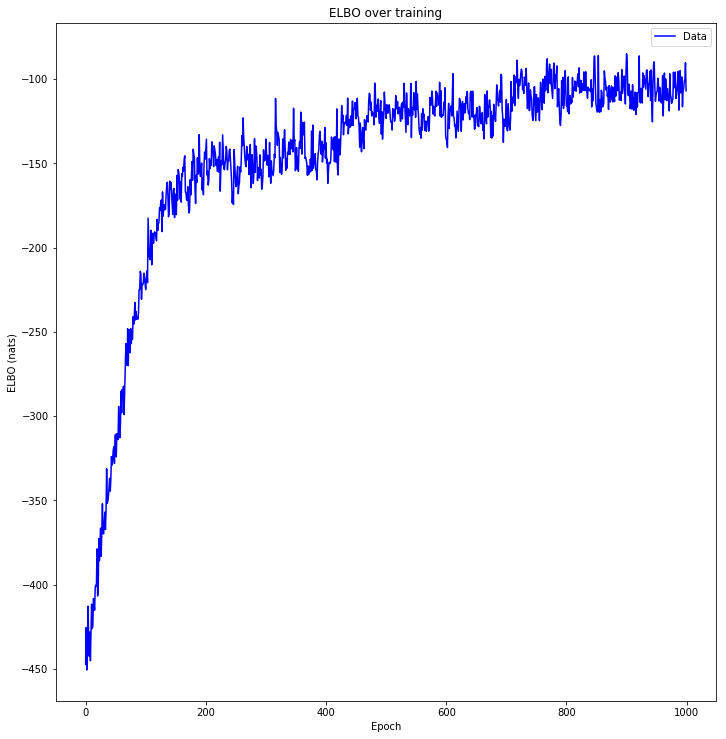

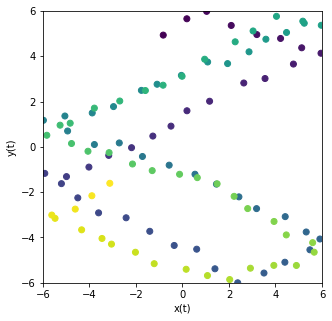

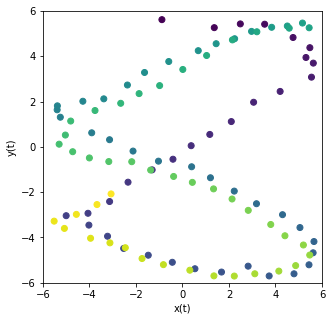

In [21]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)

    importance_sampler = training_model()
    
    inference, trained_params, elbos = importance.variational_importance(
        importance_sampler, 1000, data,
        use_cuda=False, lr=1e-1, inclusive_kl=False,
        patience=100,
    )
    utils.plot_evidence_bounds(elbos, True)
    
    bouncing_ball_posterior = mcmc.resample_move_smc(importance_sampler, moves=5)
    (direction, position, uncertainty, noise), inference, _ = bouncing_ball_posterior(data=data)
    inferred_trajectory = accumulate_trajectory(inference)
    
    positions = inferred_trajectory.mean(dim=0).cpu().detach()
    displacements = torch.stack([inference['Reduce/Step(%d)/StepBallDynamics' % t]['velocity_%d' % (t+1)].value.mean(dim=0) for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_original_trajectory(trajectory, T, s)
    graph_inferred_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    plt.close('all')

In [22]:
trained_params

"{'noise__loc': 'tensor([-1.7252, -1.6663], grad_fn=<CloneBackward>)', 'noise__scale': 'tensor([-2.3876, -2.3415], grad_fn=<CloneBackward>)', 'position_0__covariance_matrix': 'tensor([[-1.5337,  0.0000],\n        [-0.0162, -1.2323]], grad_fn=<CloneBackward>)', 'position_0__loc': 'tensor([-0.7172,  5.8629], grad_fn=<CloneBackward>)', 'uncertainty__loc': 'tensor([-0.9060, -1.3880], grad_fn=<CloneBackward>)', 'uncertainty__scale': 'tensor([-2.2487, -2.3179], grad_fn=<CloneBackward>)', 'velocities__loc': 'tensor([[ 0.8987,  0.2047],\n        [ 1.0109, -0.0275],\n        [ 1.1042, -0.3808],\n        [ 0.9708, -0.2526],\n        [ 0.9720, -0.3307],\n        [ 0.9776, -0.4016],\n        [ 1.0278, -0.4021],\n        [-1.2091, -0.5676],\n        [-1.0523, -0.4568],\n        [-1.2613, -0.6251],\n        [-0.9962, -0.5352],\n        [-0.7422, -0.5492],\n        [-0.7266, -0.5394],\n        [-0.9446, -0.4435],\n        [-1.0355, -0.4944],\n        [-0.8470, -0.4465],\n        [-0.9113, -0.3823],\n

In [23]:
for t in range(T+1):
    print('Position at time %d' % t, data['position_%d' % t])

Position at time 0 tensor([-0.8260,  4.9357])
Position at time 1 tensor([0.1893, 5.6569])
Position at time 2 tensor([1.0415, 5.9840])
Position at time 3 tensor([2.0985, 5.3621])
Position at time 4 tensor([3.1991, 4.9594])
Position at time 5 tensor([4.2205, 4.7878])
Position at time 6 tensor([5.1291, 4.3757])
Position at time 7 tensor([5.9592, 4.1349])
Position at time 8 tensor([4.7730, 3.6573])
Position at time 9 tensor([3.5522, 3.0189])
Position at time 10 tensor([2.6381, 2.8213])
Position at time 11 tensor([1.1676, 2.0162])
Position at time 12 tensor([0.1941, 1.5957])
Position at time 13 tensor([-0.4929,  0.9170])
Position at time 14 tensor([-1.2732,  0.4782])
Position at time 15 tensor([-2.1891, -0.0343])
Position at time 16 tensor([-3.1706, -0.3751])
Position at time 17 tensor([-4.0228, -0.8908])
Position at time 18 tensor([-4.9880, -1.3109])
Position at time 19 tensor([-5.9206, -1.1691])
Position at time 20 tensor([-5.2053, -1.6221])
Position at time 21 tensor([-4.5012, -2.2492])


In [24]:
for t in range(T+1):
    print('Inferred position at time %d' % t, positions[t])

Inferred position at time 0 tensor([-0.8833,  5.6184])
Inferred position at time 1 tensor([1.3688, 5.2650])
Inferred position at time 2 tensor([2.4892, 5.4305])
Inferred position at time 3 tensor([3.5355, 5.4168])
Inferred position at time 4 tensor([4.7576, 4.8301])
Inferred position at time 5 tensor([5.4802, 4.3810])
Inferred position at time 6 tensor([5.3126, 3.9476])
Inferred position at time 7 tensor([5.6286, 3.6989])
Inferred position at time 8 tensor([5.5499, 3.0793])
Inferred position at time 9 tensor([4.2017, 2.4493])
Inferred position at time 10 tensor([3.0610, 1.9713])
Inferred position at time 11 tensor([2.1012, 1.1189])
Inferred position at time 12 tensor([1.1761, 0.5505])
Inferred position at time 13 tensor([0.3749, 0.0534])
Inferred position at time 14 tensor([-0.4081, -0.5444])
Inferred position at time 15 tensor([-1.3030, -1.0133])
Inferred position at time 16 tensor([-2.3406, -1.5579])
Inferred position at time 17 tensor([-3.1331, -2.4122])
Inferred position at time 18

In [25]:
bouncing_ball_smc = importance.smc(importance_sampler)
(direction, position, uncertainty, noise), inference, _ = bouncing_ball_smc(data=data)
inferred_trajectory = accumulate_trajectory(inference)
positions = inferred_trajectory.mean(dim=0).cpu().detach()

In [26]:
for t in range(T+1):
    print('Inferred position at time %d' % t, positions[t])

Inferred position at time 0 tensor([-0.5792,  5.6943])
Inferred position at time 1 tensor([1.9441, 5.2067])
Inferred position at time 2 tensor([2.7629, 5.2781])
Inferred position at time 3 tensor([3.7802, 4.9667])
Inferred position at time 4 tensor([4.4265, 4.4499])
Inferred position at time 5 tensor([5.1339, 3.9581])
Inferred position at time 6 tensor([5.4918, 3.5249])
Inferred position at time 7 tensor([5.3255, 3.1844])
Inferred position at time 8 tensor([5.6203, 2.8030])
Inferred position at time 9 tensor([4.4253, 2.3625])
Inferred position at time 10 tensor([3.8297, 1.7282])
Inferred position at time 11 tensor([3.0949, 0.9353])
Inferred position at time 12 tensor([2.0574, 0.4458])
Inferred position at time 13 tensor([ 1.2236, -0.0613])
Inferred position at time 14 tensor([ 0.5179, -0.7113])
Inferred position at time 15 tensor([-0.3363, -1.1010])
Inferred position at time 16 tensor([-1.2804, -1.5605])
Inferred position at time 17 tensor([-2.2063, -2.0179])
Inferred position at time 

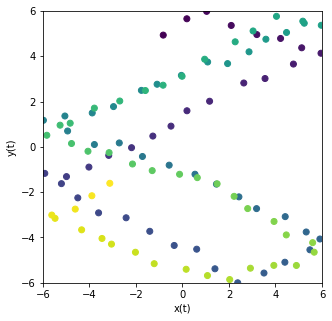

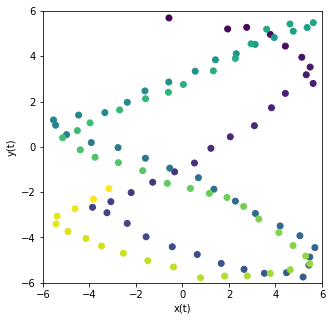

In [27]:
graph_original_trajectory(trajectory, T, s)
graph_inferred_trajectory(positions, T, s)